In [ ]:
#Importing neccassary Libraries
import numpy as np
import pandas as pd
from google.colab import files
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import tensorflow
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras import callbacks
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [ ]:
#import pandas as pd
#path="/traffic.csv"
#data=pd.read_csv(path)
#data.describe
uploaded = files.upload()

In [ ]:
import io
data = pd.read_csv(io.StringIO(uploaded['traffic.csv'].decode('utf-8')))
data.head

In [ ]:
data["DateTime"]= pd.to_datetime(data["DateTime"])
data = data.drop(["ID"], axis=1) #dropping IDs
data.info()

Text(0.5, 0, 'Date')

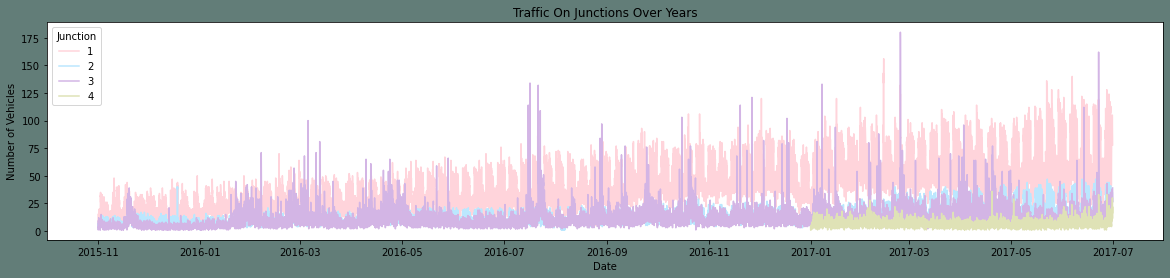

In [ ]:
#df to be used for EDA
df=data.copy()
#Let's plot the Timeseries
colors = [ "#FFD4DB","#BBE7FE","#D3B5E5","#dfe2b6"]
plt.figure(figsize=(20,4),facecolor="#627D78")
Time_series=sns.lineplot(x=df['DateTime'],y="Vehicles",data=df, hue="Junction", palette=colors)
Time_series.set_title("Traffic On Junctions Over Years")
Time_series.set_ylabel("Number of Vehicles")
Time_series.set_xlabel("Date")

In [ ]:
#Exploring more features
df["Year"]= df['DateTime'].dt.year
df["Month"]= df['DateTime'].dt.month
df["Date_no"]= df['DateTime'].dt.day
df["Hour"]= df['DateTime'].dt.hour
df["Day"]= df.DateTime.dt.strftime("%A")
df.head()

,DateTime,Junction,Vehicles,Year,Month,Date_no,Hour,Day
0,2015-11-01 00:00:00,1,15,2015,11,1,0,Sunday
1,2015-11-01 01:00:00,1,13,2015,11,1,1,Sunday
2,2015-11-01 02:00:00,1,10,2015,11,1,2,Sunday
3,2015-11-01 03:00:00,1,7,2015,11,1,3,Sunday
4,2015-11-01 04:00:00,1,9,2015,11,1,4,Sunday


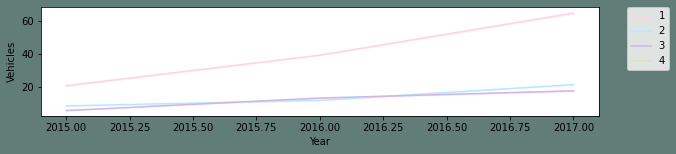

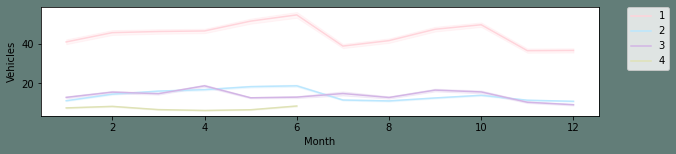

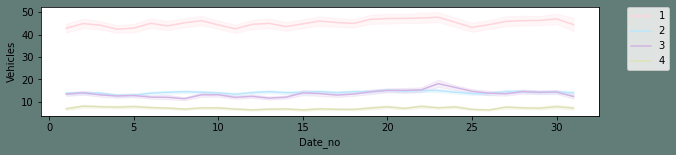

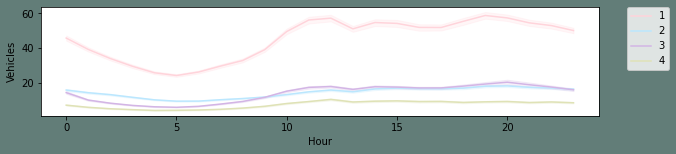

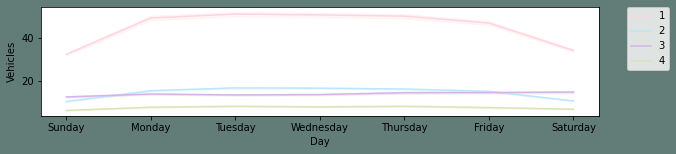

In [ ]:
#Let's plot the Timeseries
new_features = [ "Year","Month", "Date_no", "Hour", "Day"]

for i in new_features:
    plt.figure(figsize=(10,2),facecolor="#627D78")
    ax=sns.lineplot(x=df[i],y="Vehicles",data=df, hue="Junction", palette=colors )
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Text(0.5, 0, 'Date')

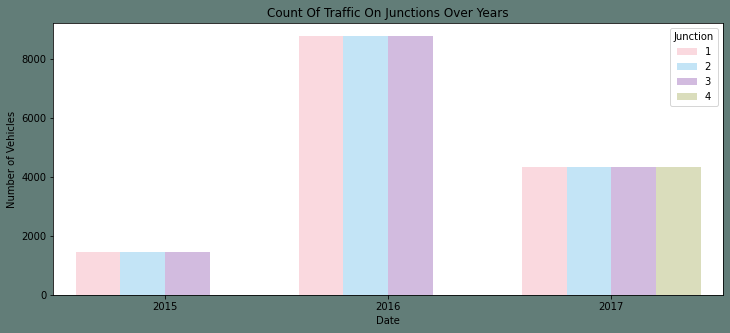

In [ ]:
plt.figure(figsize=(12,5),facecolor="#627D78")
count = sns.countplot(data=df, x =df["Year"], hue="Junction", palette=colors)
count.set_title("Count Of Traffic On Junctions Over Years")
count.set_ylabel("Number of Vehicles")
count.set_xlabel("Date")

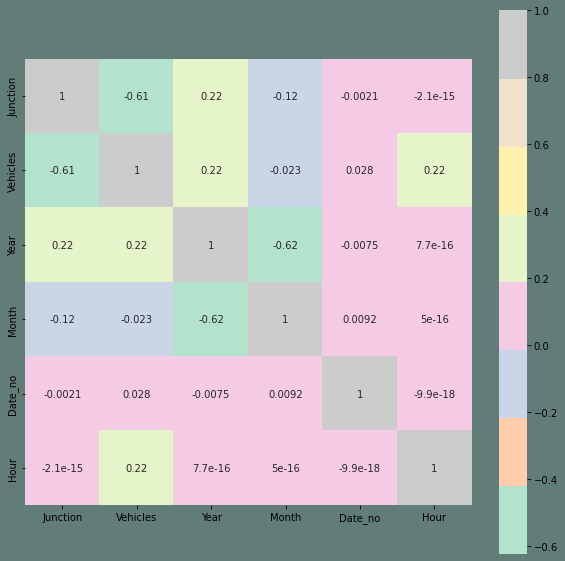

In [ ]:
corrmat = df.corr()
plt.subplots(figsize=(10,10),facecolor="#627D78")
sns.heatmap(corrmat,cmap= "Pastel2",annot=True,square=True, )

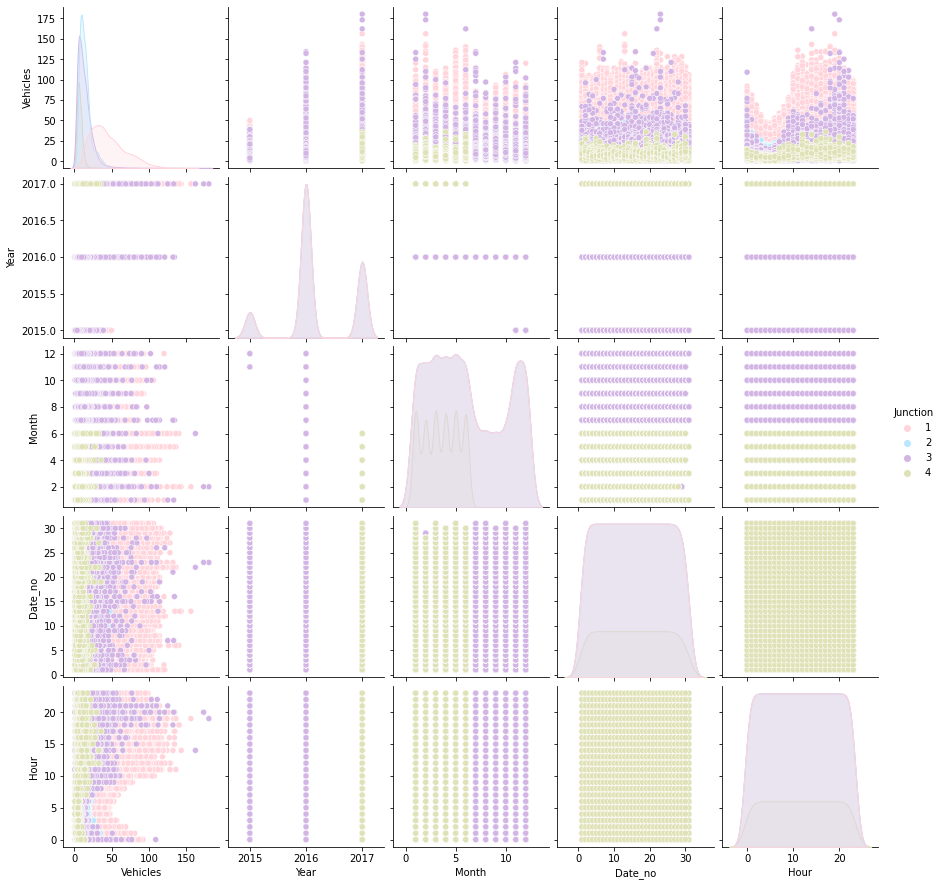

In [ ]:
sns.pairplot(data=df, hue= "Junction",palette=colors)

In [ ]:
df_J = data.pivot(columns="Junction", index="DateTime")
df_J.describe()

Vehicles                                         
Junction             1             2             3            4
count     14592.000000  14592.000000  14592.000000  4344.000000
mean         45.052906     14.253221     13.694010     7.251611
std          23.008345      7.401307     10.436005     3.521455
min           5.000000      1.000000      1.000000     1.000000
25%          27.000000      9.000000      7.000000     5.000000
50%          40.000000     13.000000     11.000000     7.000000
75%          59.000000     17.000000     18.000000     9.000000
max         156.000000     48.000000    180.000000    36.000000

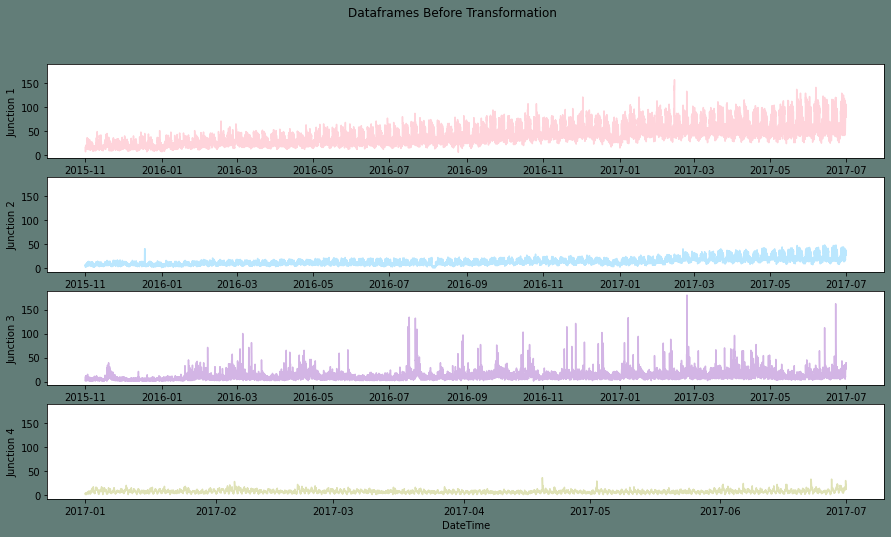

In [ ]:
df_1 = df_J[[('Vehicles', 1)]]
df_2 = df_J[[('Vehicles', 2)]]
df_3 = df_J[[('Vehicles', 3)]]
df_4 = df_J[[('Vehicles', 4)]]
df_4 = df_4.dropna() #Junction 4 has limited data only for a few months

#Dropping level one in dfs's index as it is a multi index data frame
list_dfs = [df_1, df_2, df_3, df_4]
for i in list_dfs:
    i.columns= i.columns.droplevel(level=1)

#Function to plot comparitive plots of dataframes
def Sub_Plots4(df_1, df_2,df_3,df_4,title):
    fig, axes = plt.subplots(4, 1, figsize=(15, 8),facecolor="#627D78", sharey=True)
    fig.suptitle(title)
    #J1
    pl_1=sns.lineplot(ax=axes[0],data=df_1,color=colors[0])
    #pl_1=plt.ylabel()
    axes[0].set(ylabel ="Junction 1")
    #J2
    pl_2=sns.lineplot(ax=axes[1],data=df_2,color=colors[1])
    axes[1].set(ylabel ="Junction 2")
    #J3
    pl_3=sns.lineplot(ax=axes[2],data=df_3,color=colors[2])
    axes[2].set(ylabel ="Junction 3")
    #J4
    pl_4=sns.lineplot(ax=axes[3],data=df_4,color=colors[3])
    axes[3].set(ylabel ="Junction 4")


#Plotting the dataframe to check for stationarity
Sub_Plots4(df_1.Vehicles, df_2.Vehicles,df_3.Vehicles,df_4.Vehicles,"Dataframes Before Transformation")

In [ ]:
# Normalize Function
def Normalize(df,col):
    average = df[col].mean()
    stdev = df[col].std()
    df_normalized = (df[col] - average) / stdev
    df_normalized = df_normalized.to_frame()
    return df_normalized, average, stdev

# Differencing Function
def Difference(df,col, interval):
    diff = []
    for i in range(interval, len(df)):
        value = df[col][i] - df[col][i - interval]
        diff.append(value)
    return diff

In [ ]:
#Normalizing and Differencing to make the series stationary
df_N1, av_J1, std_J1 = Normalize(df_1, "Vehicles")
Diff_1 = Difference(df_N1, col="Vehicles", interval=(24*7)) #taking a week's diffrence
df_N1 = df_N1[24*7:]
df_N1.columns = ["Norm"]
df_N1["Diff"]= Diff_1

df_N2, av_J2, std_J2 = Normalize(df_2, "Vehicles")
Diff_2 = Difference(df_N2, col="Vehicles", interval=(24)) #taking a day's diffrence
df_N2 = df_N2[24:]
df_N2.columns = ["Norm"]
df_N2["Diff"]= Diff_2

df_N3, av_J3, std_J3 = Normalize(df_3, "Vehicles")
Diff_3 = Difference(df_N3, col="Vehicles", interval=1) #taking an hour's diffrence
df_N3 = df_N3[1:]
df_N3.columns = ["Norm"]
df_N3["Diff"]= Diff_3

df_N4, av_J4, std_J4 = Normalize(df_4, "Vehicles")
Diff_4 = Difference(df_N4, col="Vehicles", interval=1) #taking an hour's diffrence
df_N4 = df_N4[1:]
df_N4.columns = ["Norm"]
df_N4["Diff"]= Diff_4

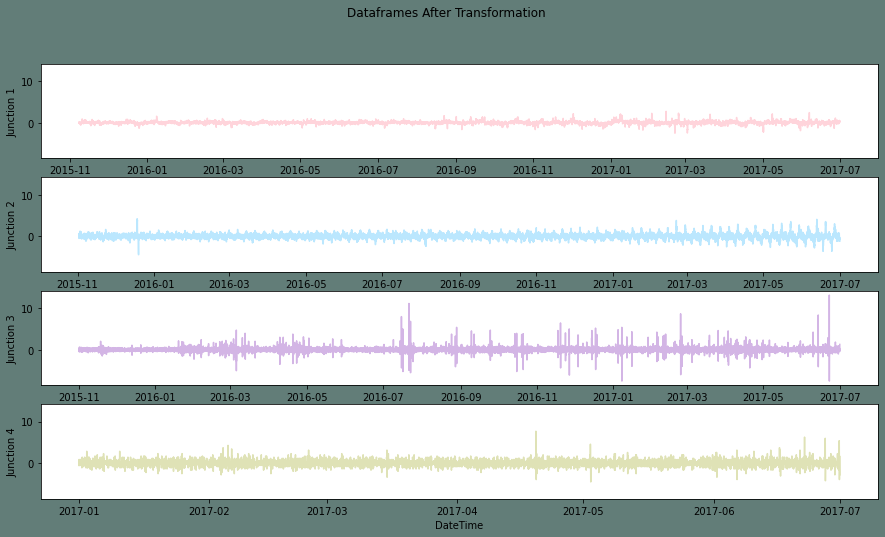

In [ ]:
Sub_Plots4(df_N1.Diff, df_N2.Diff,df_N3.Diff,df_N4.Diff,"Dataframes After Transformation")

In [ ]:
#Stationary Check for the time series Augmented Dickey Fuller test
def Stationary_check(df):
    check = adfuller(df.dropna())
    print(f"ADF Statistic: {check[0]}")
    print(f"p-value: {check[1]}")
    print("Critical Values:")
    for key, value in check[4].items():
        print('\t%s: %.3f' % (key, value))
    if check[0] > check[4]["1%"]:
        print("Time Series is Non-Stationary")
    else:
        print("Time Series is Stationary")


#Checking if the series is stationary

List_df_ND = [ df_N1["Diff"], df_N2["Diff"], df_N3["Diff"], df_N4["Diff"]]
print("Checking the transformed series for stationarity:")
for i in List_df_ND:
    print("\n")
    Stationary_check(i)

Checking the transformed series for stationarity:


ADF Statistic: -15.265303390415573
p-value: 4.798539876394827e-28
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -21.795891026940076
p-value: 0.0
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -28.00175990883259
p-value: 0.0
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -17.979092563052358
p-value: 2.7787875325952613e-30
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Time Series is Stationary


In [ ]:
#Differencing created some NA values as we took a weeks data into consideration while difrencing
df_J1 = df_N1["Diff"].dropna()
df_J1 = df_J1.to_frame()

df_J2 = df_N2["Diff"].dropna()
df_J2 = df_J2.to_frame()

df_J3 = df_N3["Diff"].dropna()
df_J3 = df_J3.to_frame()

df_J4 = df_N4["Diff"].dropna()
df_J4 = df_J4.to_frame()

#Splitting the dataset
def Split_data(df):
    training_size = int(len(df)*0.90)
    data_len = len(df)
    train, test = df[0:training_size],df[training_size:data_len]
    train, test = train.values.reshape(-1, 1), test.values.reshape(-1, 1)
    return train, test
#Splitting the training and test datasets
J1_train, J1_test = Split_data(df_J1)
J2_train, J2_test = Split_data(df_J2)
J3_train, J3_test = Split_data(df_J3)
J4_train, J4_test = Split_data(df_J4)

#Target and Feature
def TnF(df):
    end_len = len(df)
    X = []
    y = []
    steps = 32
    for i in range(steps, end_len):
        X.append(df[i - steps:i, 0])
        y.append(df[i, 0])
    X, y = np.array(X), np.array(y)
    return X ,y

#fixing the shape of X_test and X_train
def FeatureFixShape(train, test):
    train = np.reshape(train, (train.shape[0], train.shape[1], 1))
    test = np.reshape(test, (test.shape[0],test.shape[1],1))
    return train, test

#Assigning features and target
X_trainJ1, y_trainJ1 = TnF(J1_train)
X_testJ1, y_testJ1 = TnF(J1_test)
X_trainJ1, X_testJ1 = FeatureFixShape(X_trainJ1, X_testJ1)

X_trainJ2, y_trainJ2 = TnF(J2_train)
X_testJ2, y_testJ2 = TnF(J2_test)
X_trainJ2, X_testJ2 = FeatureFixShape(X_trainJ2, X_testJ2)

X_trainJ3, y_trainJ3 = TnF(J3_train)
X_testJ3, y_testJ3 = TnF(J3_test)
X_trainJ3, X_testJ3 = FeatureFixShape(X_trainJ3, X_testJ3)

X_trainJ4, y_trainJ4 = TnF(J4_train)
X_testJ4, y_testJ4 = TnF(J4_test)
X_trainJ4, X_testJ4 = FeatureFixShape(X_trainJ4, X_testJ4)

In [ ]:
#Model for the prediction
def GRU_model(X_Train, y_Train, X_Test):
    early_stopping = callbacks.EarlyStopping(min_delta=0.001,patience=10, restore_best_weights=True)
    #callback delta 0.01 may interrupt the learning, could eliminate this step, but meh!

    #The GRU model
    model = Sequential()
    model.add(GRU(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    #model.add(GRU(units=50, return_sequences=True,  input_shape=(X_Train.shape[1],1),activation='tanh'))
    #model.add(Dropout(0.2))
    model.add(GRU(units=50, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    #Compiling the model
    model.compile(optimizer=SGD(decay=1e-7, momentum=0.9),loss='mean_squared_error')
    model.fit(X_Train,y_Train, epochs=3, batch_size=150,callbacks=[early_stopping])
    pred_GRU= model.predict(X_Test)
    return pred_GRU

#To calculate the root mean squred error in predictions
def RMSE_Value(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))
    return rmse

#To plot the comparitive plot of targets and predictions
def PredictionsPlot(test,predicted,m):
    plt.figure(figsize=(12,5),facecolor="#627D78")
    plt.plot(test, color=colors[m],label="True Value",alpha=0.5 )
    plt.plot(predicted, color="#627D78",label="Predicted Values")
    plt.title("GRU Traffic Prediction Vs True values")
    plt.xlabel("DateTime")
    plt.ylabel("Number of Vehicles")
    plt.legend()
    plt.show()

In [ ]:
#Predictions For First Junction
PredJ1 = GRU_model(X_trainJ1,y_trainJ1,X_testJ1)

Epoch 1/3
87/87 [==============================] - ETA: 0s - loss: 0.0777

87/87 [==============================] - 55s 479ms/step - loss: 0.0777
Epoch 2/3
87/87 [==============================] - ETA: 0s - loss: 0.0673

87/87 [==============================] - 44s 508ms/step - loss: 0.0673
Epoch 3/3
87/87 [==============================] - ETA: 0s - loss: 0.0659

45/45 [==============================] - 5s 56ms/step


The root mean squared error is 0.2990187239589371.


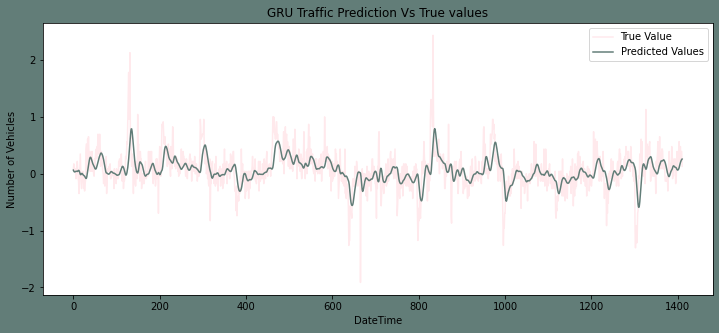

In [ ]:
#Results for J1
RMSE_J1=RMSE_Value(y_testJ1,PredJ1)
PredictionsPlot(y_testJ1,PredJ1,0)

In [ ]:
PredJ2 = GRU_model(X_trainJ2,y_trainJ2,X_testJ2)

Epoch 1/3
88/88 [==============================] - ETA: 0s - loss: 0.2353

88/88 [==============================] - 56s 482ms/step - loss: 0.2353
Epoch 2/3
88/88 [==============================] - ETA: 0s - loss: 0.2061

88/88 [==============================] - 43s 483ms/step - loss: 0.2061
Epoch 3/3
88/88 [==============================] - ETA: 0s - loss: 0.1998

45/45 [==============================] - 5s 57ms/step


The root mean squared error is 0.6047034280186913.


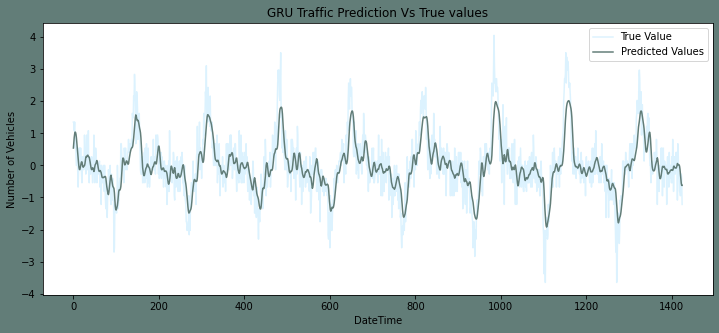

In [ ]:
#Results for J2
RMSE_J2=RMSE_Value(y_testJ2,PredJ2)
PredictionsPlot(y_testJ2,PredJ2,1)

In [ ]:
#Predictions For Third Junction
PredJ3 = GRU_model(X_trainJ3,y_trainJ3,X_testJ3)

Epoch 1/3
88/88 [==============================] - ETA: 0s - loss: 0.3025

88/88 [==============================] - 56s 481ms/step - loss: 0.3025
Epoch 2/3
88/88 [==============================] - ETA: 0s - loss: 0.2958

88/88 [==============================] - 43s 486ms/step - loss: 0.2958
Epoch 3/3
88/88 [==============================] - ETA: 0s - loss: 0.2903

45/45 [==============================] - 5s 56ms/step


The root mean squared error is 0.6316542197696622.


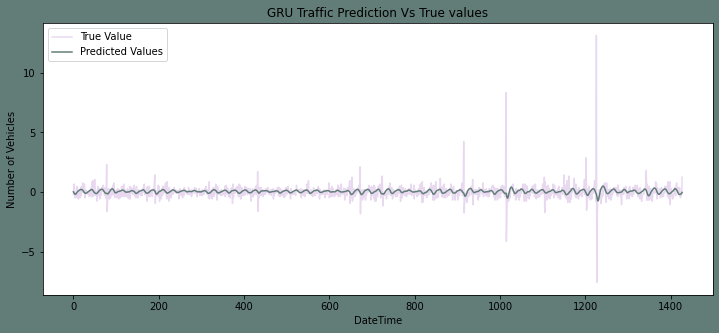

In [ ]:
#Results for J3
RMSE_J3=RMSE_Value(y_testJ3,PredJ3)
PredictionsPlot(y_testJ3,PredJ3,2)

In [ ]:
#Predictions For Forth Junction
PredJ4 = GRU_model(X_trainJ4,y_trainJ4,X_testJ4)

Epoch 1/3
26/26 [==============================] - ETA: 0s - loss: 0.6928

26/26 [==============================] - 26s 481ms/step - loss: 0.6928
Epoch 2/3
26/26 [==============================] - ETA: 0s - loss: 0.6901

26/26 [==============================] - 12s 478ms/step - loss: 0.6901
Epoch 3/3
26/26 [==============================] - ETA: 0s - loss: 0.6909

13/13 [==============================] - 3s 57ms/step


The root mean squared error is 1.1115112093900414.


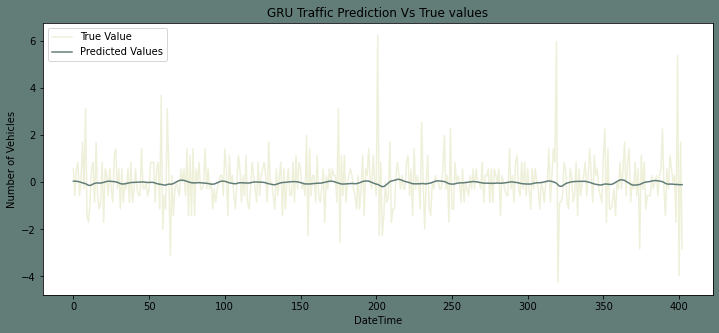

In [ ]:
#Results for J4
RMSE_J4=RMSE_Value(y_testJ4,PredJ4)
PredictionsPlot(y_testJ4,PredJ4,3)

In [ ]:
# Functions to inverse transforms and Plot comparitive plots
# invert differenced forecast
def inverse_difference(last_ob, value):
    inversed = value + last_ob
    return inversed
#Plotting the comparison
def Sub_Plots2(df_1, df_2,title,m):
    fig, axes = plt.subplots(1, 2, figsize=(18,4), sharey=True,facecolor="#627D78")
    fig.suptitle(title)

    pl_1=sns.lineplot(ax=axes[0],data=df_1,color=colors[m])
    axes[0].set(ylabel ="Prediction")

    pl_2=sns.lineplot(ax=axes[1],data=df_2["Vehicles"],color="#627D78")
    axes[1].set(ylabel ="Orignal")

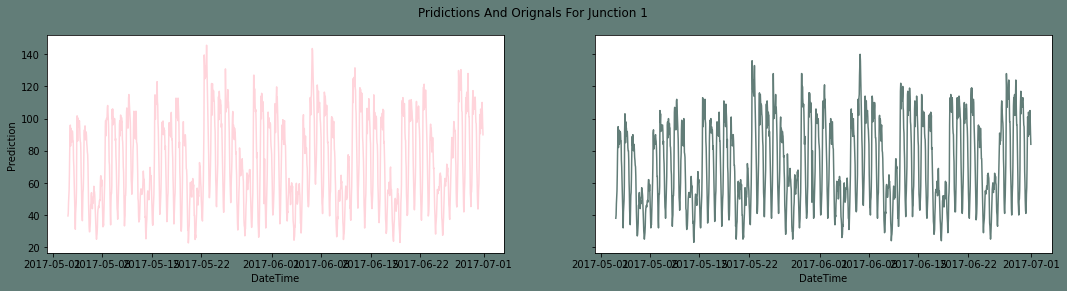

In [ ]:
# invert the differenced forecast for Junction 1
recover1 = df_N1.Norm[-1412:-1].to_frame()
recover1["Pred"]= PredJ1
Transform_reverssed_J1 = inverse_difference(recover1.Norm, recover1.Pred).to_frame()
Transform_reverssed_J1.columns = ["Pred_Normed"]
#Invert the normalizeation J1
Final_J1_Pred = (Transform_reverssed_J1.values* std_J1) + av_J1
Transform_reverssed_J1["Pred_Final"] =Final_J1_Pred
#Plotting the Predictions with orignals
Sub_Plots2(Transform_reverssed_J1["Pred_Final"], df_1[-1412:-1],"Pridictions And Orignals For Junction 1", 0)

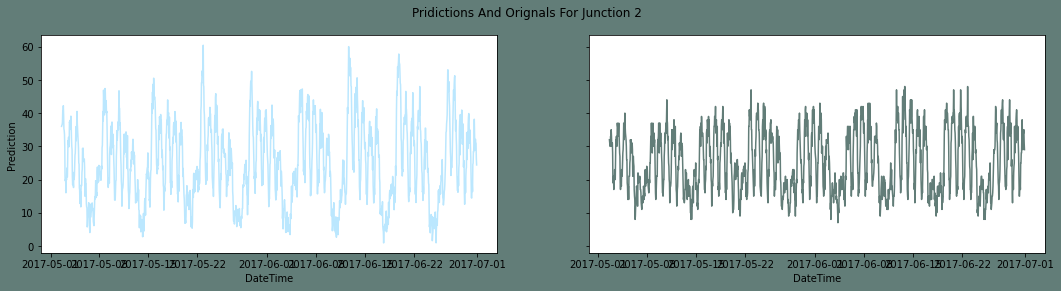

In [ ]:
#Invert the differenced J2
recover2 = df_N2.Norm[-1426:-1].to_frame() #len as per the diff
recover2["Pred"]= PredJ2
Transform_reverssed_J2 = inverse_difference(recover2.Norm, recover2.Pred).to_frame()
Transform_reverssed_J2.columns = ["Pred_Normed"]
Final_J2_Pred = (Transform_reverssed_J2.values* std_J2) + av_J2
Transform_reverssed_J2["Pred_Final"] =Final_J2_Pred
#Plotting the Predictions with orignals
Sub_Plots2(Transform_reverssed_J2["Pred_Final"], df_2[-1426:-1],"Pridictions And Orignals For Junction 2", 1)

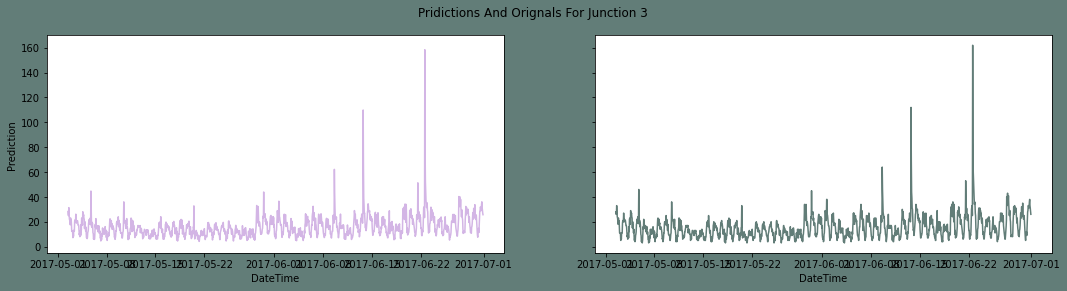

In [ ]:
#Invert the differenced J3
recover3 = df_N3.Norm[-1429:-1].to_frame() #len as per the diff
recover3["Pred"]= PredJ3
Transform_reverssed_J3 = inverse_difference(recover3.Norm, recover3.Pred).to_frame()
Transform_reverssed_J3.columns = ["Pred_Normed"]
#Invert the normalizeation J3
Final_J3_Pred = (Transform_reverssed_J3.values* std_J3) + av_J3
Transform_reverssed_J3["Pred_Final"] =Final_J3_Pred
Sub_Plots2(Transform_reverssed_J3["Pred_Final"], df_3[-1429:-1],"Pridictions And Orignals For Junction 3", 2)

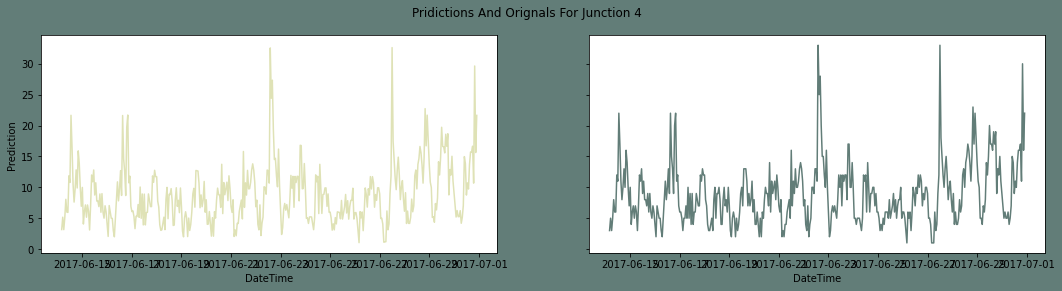

In [ ]:
#Invert the differenced J4
recover4 = df_N4.Norm[-404:-1].to_frame()  #len as per the testset
recover4["Pred"]= PredJ4
Transform_reverssed_J4 = inverse_difference(recover4.Norm, recover4.Pred).to_frame()
Transform_reverssed_J4.columns = ["Pred_Normed"]
#Invert the normalizeation J4
Final_J4_Pred = (Transform_reverssed_J4.values* std_J4) + av_J4
Transform_reverssed_J4["Pred_Final"] =Final_J4_Pred
Sub_Plots2(Transform_reverssed_J4["Pred_Final"], df_4[-404:-1],"Pridictions And Orignals For Junction 4", 3)